In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, AutoConfig
from transformers.models.bert.modeling_bert import BertEmbeddings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import pickle
from load_model import *

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Load LSTM model

In [3]:
lstm_path = './model/LSTM_classifier.pt'
lstm_model = load_LSTMClassifier(lstm_path, device)

## Load BERT model

In [4]:
bert_model_path = './model/Bert_classifier.pth'
pretrained_path = './pretrained/bert-base-uncased'

bert_model = load_BERTClassifier(bert_model_path, pretrained_path, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./pretrained/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define predict function for LSTM and BERT

In [5]:
def predict(lstm_model, bert_model, dataloader):
    lstm_pred_list = []
    bert_pred_list = []
    label_list = []

    lstm_model.eval()
    bert_model.eval()
    with torch.no_grad():
        for X, attention_mask, Y in dataloader:
            cur_batch = len(X)
            hidden = lstm_model.init_hidden(cur_batch)

            X = X.cuda()
            attention_mask = attention_mask.cuda()
            
            lstm_pred, hidden = lstm_model(X, hidden)
            bert_pred = bert_model(X, attention_mask=attention_mask, token_type_ids=None)

            lstm_pred = lstm_pred.cpu().numpy()
            lstm_pred_list.append(lstm_pred.tolist())

            bert_pred = bert_pred['logits'].cpu()
            bert_pred = nn.functional.softmax(bert_pred, dim=1)
            bert_pred_list.append(bert_pred.numpy().tolist())

            label_list.append(Y.cpu().numpy())

    return lstm_pred_list, bert_pred_list, label_list

## Load dataset

In [6]:
df = pd.read_csv('./data/test.csv')
X = df['text']
Y = df['suicide']

In [7]:
sentences = [sen for sen in X]
sen_labels = torch.tensor(Y.values)

### Check whether test dataset is balanced

In [8]:
print(df.groupby('suicide')['text'].count())

suicide
0    23187
1    23226
Name: text, dtype: int64


### Tokenized with bert tokenizer

In [9]:
# get pre-trained tokenizer model
tokenizer = BertTokenizer.from_pretrained(pretrained_path)

tokenizer

BertTokenizer(name_or_path='./pretrained/bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [10]:
max_length = 512

tokenized = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

sen_ids = tokenized['input_ids']
attention_mask = tokenized['attention_mask']

### Wrap dataset into a Dataloader object

In [11]:
dataset = TensorDataset(sen_ids, attention_mask, sen_labels)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## Predict the data

In [12]:
lstm_preds, bert_preds, labels = predict(lstm_model, bert_model, dataloader)

In [13]:
lstm_preds = np.array(lstm_preds).reshape(-1, 2)
bert_preds = np.array(bert_preds).reshape(-1, 2)
labels = np.array(labels).flatten()

## Draw confusion matrixs for all models

### LSTM

<Figure size 640x480 with 0 Axes>

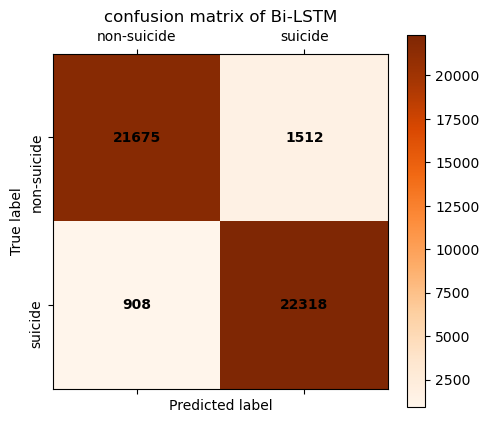

              precision    recall  f1-score   support

           0       0.96      0.93      0.95     23187
           1       0.94      0.96      0.95     23226

    accuracy                           0.95     46413
   macro avg       0.95      0.95      0.95     46413
weighted avg       0.95      0.95      0.95     46413



In [14]:
y_pred = lstm_preds.argmax(1)
cm = confusion_matrix(labels, y_pred)
plt.figure()
plt.matshow(cm, cmap=plt.cm.Oranges)
plt.colorbar(fraction=0.05)
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x, y], xy=(y, x), horizontalalignment='center', verticalalignment='center', weight='heavy')

plt.xlabel('Predicted label')
plt.xticks([1, 0], ['suicide', 'non-suicide'])
plt.ylabel('True label')
plt.yticks([1, 0], ['suicide', 'non-suicide'], rotation=90)
plt.title('confusion matrix of Bi-LSTM')
plt.savefig('./img/cm_LSTM.jpg')
plt.show()

print(classification_report(labels, y_pred))

### BERT

<Figure size 640x480 with 0 Axes>

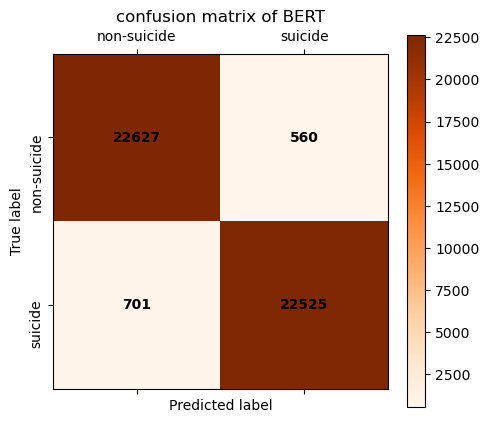

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     23187
           1       0.98      0.97      0.97     23226

    accuracy                           0.97     46413
   macro avg       0.97      0.97      0.97     46413
weighted avg       0.97      0.97      0.97     46413



In [15]:
y_pred = bert_preds.argmax(1)
cm = confusion_matrix(labels, y_pred)
plt.figure()
plt.matshow(cm, cmap=plt.cm.Oranges)
plt.colorbar(fraction=0.05)
for x in range(len(cm)):
    for y in range(len(cm)):
        plt.annotate(cm[x, y], xy=(y, x), horizontalalignment='center', verticalalignment='center', weight='heavy')

plt.xlabel('Predicted label')
plt.xticks([1, 0], ['suicide', 'non-suicide'])
plt.ylabel('True label')
plt.yticks([1, 0], ['suicide', 'non-suicide'], rotation=90)
plt.title('confusion matrix of BERT')
plt.savefig('./img/cm_BERT.jpg')
plt.show()

print(classification_report(labels, y_pred))

## Draw ROC curves for both models

In [16]:
lstm_preds_score = lstm_preds[:, 1]
bert_preds_score = bert_preds[:, 1]

### ROC curve for LSTM

In [17]:
# compute ROC curve
lstm_fpr, lstm_tpr, _ = roc_curve(labels, lstm_preds_score)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)

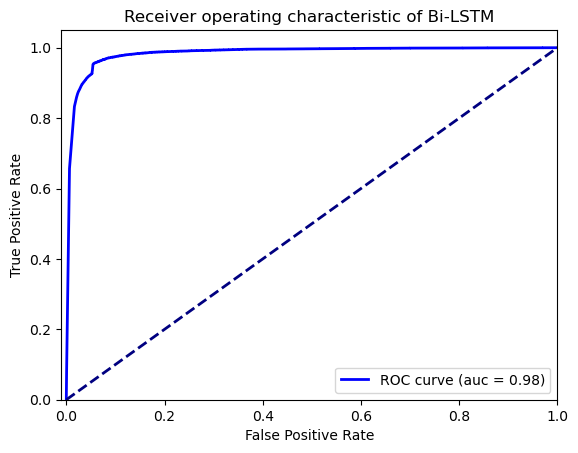

In [27]:
# plot ROC curve
plt.figure()
lw = 2
plt.plot(lstm_fpr, lstm_tpr, color='blue',
         lw=lw, label='ROC curve (auc = %0.2f)' % lstm_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Bi-LSTM')
plt.legend(loc="lower right")
plt.savefig('./img/roc_LSTM.jpg')
plt.show()

### ROC curve for BERT

In [19]:
bert_fpr, bert_tpr, bert_th = roc_curve(labels, bert_preds_score)
bert_roc_auc = auc(bert_fpr, bert_tpr)

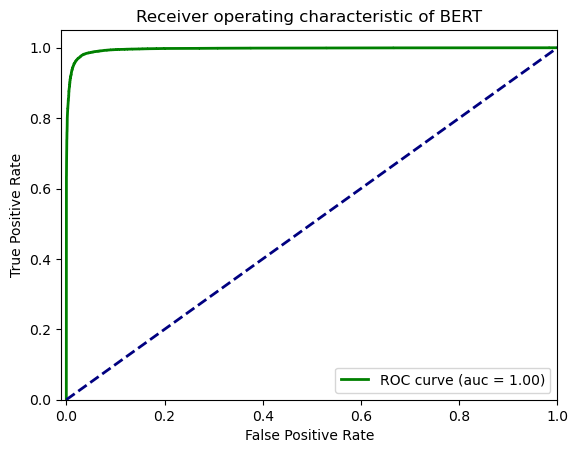

In [28]:
plt.figure()
lw = 2
plt.plot(bert_fpr, bert_tpr, color='green',
         lw=lw, label='ROC curve (auc = %0.2f)' % bert_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of BERT')
plt.legend(loc="lower right")
plt.savefig('./img/roc_BERT.jpg')
plt.show()

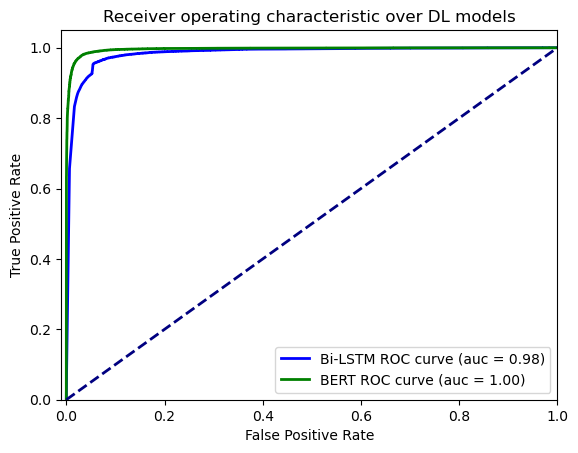

In [21]:
plt.figure()
plt.plot(lstm_fpr, lstm_tpr, color='blue',
         lw=lw, label='Bi-LSTM ROC curve (auc = %0.2f)' % lstm_roc_auc)
plt.plot(bert_fpr, bert_tpr, color='green',
         lw=lw, label='BERT ROC curve (auc = %0.2f)' % bert_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver operating characteristic over DL models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('./img/roc_BERT&LSTM.jpg')
plt.show()

## Plot PR Curve

### PR Curve for LSTM

In [22]:
# compute PR curve
lstm_pre, lstm_rec, _ = precision_recall_curve(labels, lstm_preds_score)

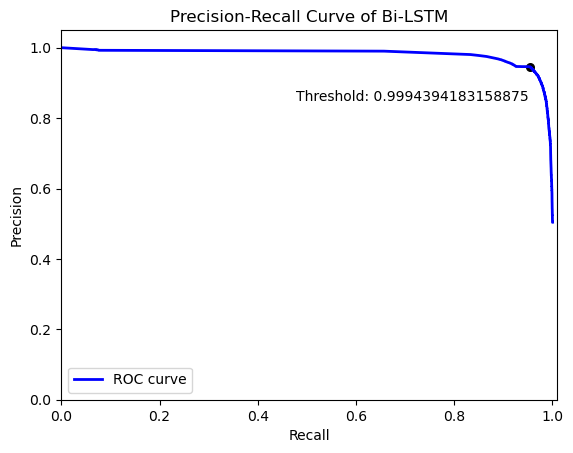

In [23]:
# plot PR curve
plt.figure()
lw = 2
plt.plot(lstm_rec, lstm_pre, color='blue',
         lw=lw, label='ROC curve')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of Bi-LSTM')
plt.legend(loc="lower left")
plt.savefig('./img/pr_LSTM.jpg')
plt.show()

### PR Curve for BERT

In [24]:
bert_pre, bert_rec, bert_th = precision_recall_curve(labels, bert_preds_score)

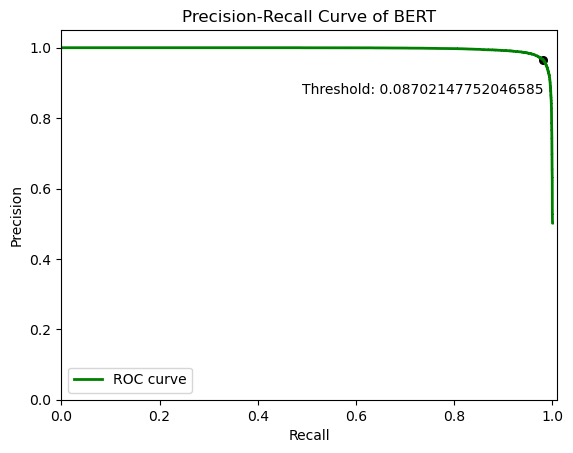

In [25]:
plt.figure()
lw = 2
plt.plot(bert_rec, bert_pre, color='green',
         lw=lw, label='ROC curve')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve of BERT')
plt.legend(loc="lower left")
plt.savefig('./img/pr_BERT.jpg')
plt.show()

### PR Curve for both models

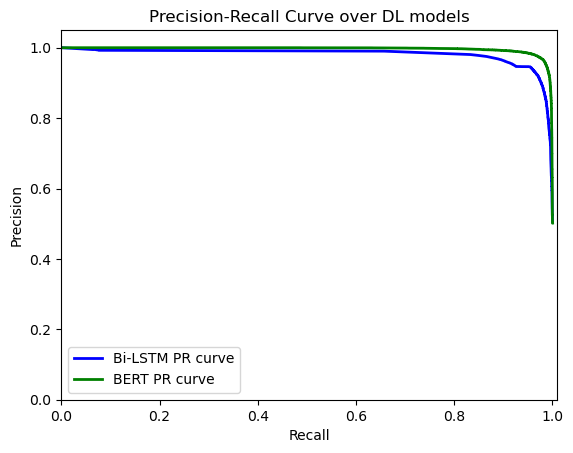

In [26]:
plt.figure()
plt.plot(lstm_rec, lstm_pre, color='blue',
         lw=lw, label='Bi-LSTM PR curve')
plt.plot(bert_rec, bert_pre, color='green',
         lw=lw, label='BERT PR curve')
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve over DL models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.savefig('./img/pr_BERT&LSTM.jpg')
plt.show()